# A Data Science Case Study on COVID-19

A Data Science based analysis on the publicly available COVID-19 datasets

![](https://images.newscientist.com/wp-content/uploads/2020/02/11165812/c0481846-wuhan_novel_coronavirus_illustration-spl.jpg)

### Acknowledgements

#### Datasets
 - https://www.kaggle.com/koryto/countryinfo
 - https://github.com/CSSEGISandData
 - https://ourworldindata.org/coronavirus-testing


In [54]:
pip install pycountry_convert

Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install us

Note: you may need to restart the kernel to use updated packages.


In [56]:
#pip install fbprophet

In [57]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


### Required Imports

In [16]:
import pandas as pd
import numpy as np
import plotly
import pycountry
import pycountry_convert as pc
import plotly_express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
pd.set_option('display.max_rows',2000,'display.max_columns',2000)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import geopy as geo
import seaborn as sns
import us
import datetime

In [21]:
datetime.__version__

AttributeError: module 'datetime' has no attribute '__version__'

## Get Realtime Data

In [59]:
JHU_Global_CC_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
JHU_US_CC_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
JHU_Global_Death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
JHU_US_Death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
JHU_Global_Recov_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
covid_test_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [60]:
def getABBR(statename):
    
    if statename in ( 'American Samoa','Diamond Princess','Grand Princess', 'Guam','Northern Mariana Islands','Virgin Islands'):
        return '0'    
    try:
        state = us.states.lookup(statename)    
    except:
        return '0'
    
    if state == None:
        return '0'
    
    return state.abbr

def Restructure_df(df,new_columns):
    
    for x in range(df.shape[0]):
    
        temp = df.drop(labels = ['Province/State','Country/Region','Lat','Long'],axis = 1).iloc[x].reset_index()

        temp.columns = ['Date',new_columns]
        temp['Country/Region'] = (df.iloc[x]['Country/Region'])
        temp['Province/State'] = (df.iloc[x]['Province/State'])
        temp['Lat'] = (df.iloc[x]['Lat'])
        temp['Long'] = (df.iloc[x]['Long'])
        temp['Date'] = temp['Date'].astype(np.datetime64)
        if x == 0:
            covid_df = pd.DataFrame(data = temp)
        else:
            covid_df = covid_df.append(temp)
            
    covid_df = covid_df.groupby(by= ['Country/Region','Date'])[new_columns].sum().reset_index()
            
    count = 0
    for country in covid_df['Country/Region'].unique():
        count += 1
        Covid_country = covid_df[covid_df['Country/Region']==country].reset_index(drop = True)  
        Daily_stats = Covid_country[new_columns].diff()
        Daily_stats.loc[0] = Covid_country.iloc[0][new_columns]
        daily = 'Daily '+ new_columns
        Covid_country[daily] = Daily_stats
        if count == 1:
            covid_df_country = pd.DataFrame(data = Covid_country)
        else:
            covid_df_country = covid_df_country.append(Covid_country)    


    return covid_df_country.reset_index(drop = True)
    
    
def Restructure_USA_df(df,new_columns):
    
    for x in range(df.shape[0]):
    
        temp = df.drop(labels = ['UID','iso2','iso3','code3','FIPS','Admin2','Combined_Key','Province_State','Country_Region','Lat','Long_'],axis = 1).iloc[x].reset_index()

        temp.columns = ['Date',new_columns]
        #temp['Country_Region'] = (df.iloc[x]['Country_Region'])
        temp['Province_State'] = (df.iloc[x]['Province_State'])
        temp['Lat'] = (df.iloc[x]['Lat'])
        temp['Long_'] = (df.iloc[x]['Long_'])
        temp['iso2'] = (df.iloc[x]['iso2'])
        temp['iso3'] = (df.iloc[x]['iso3'])
        temp['Date'] = temp['Date'].astype(np.datetime64)
        if x == 0:
            covid_df = pd.DataFrame(data = temp)
        else:
            covid_df = covid_df.append(temp)
            
    covid_USA_df = covid_df.groupby(by= ['Province_State','Date'])[new_columns].sum().reset_index()

    return covid_USA_df.reset_index(drop = True)

In [61]:
class country_utils():
    def __init__(self):
        self.d = {}
    
    def get_dic(self):
        return self.d
    
    def get_country_details(self,country):
        """Returns country code(alpha_3) and continent"""
        try:
            country_obj = pycountry.countries.get(name=country)
            if country_obj is None:
                c = pycountry.countries.search_fuzzy(country)
                country_obj = c[0]
            continent_code = pc.country_alpha2_to_continent_code(country_obj.alpha_2)
            continent = pc.convert_continent_code_to_continent_name(continent_code)
            return country_obj.alpha_3, continent
        except:
            if 'Congo' in country:
                country = 'Congo'
            elif country == 'Diamond Princess' or country == 'Laos' or country == 'MS Zaandam'\
            or country == 'Holy See' or country == 'Timor-Leste':
                return country, country
            elif country == 'Korea, South' or country == 'South Korea':
                country = 'Korea, Republic of'
            elif country == 'Taiwan*':
                country = 'Taiwan'
            elif country == 'Burma':
                country = 'Myanmar'
            elif country == 'West Bank and Gaza':
                country = 'Gaza'
            else:
                return country, country
            country_obj = pycountry.countries.search_fuzzy(country)
            continent_code = pc.country_alpha2_to_continent_code(country_obj[0].alpha_2)
            continent = pc.convert_continent_code_to_continent_name(continent_code)
            return country_obj[0].alpha_3, continent
    
    def get_iso3(self, country):
        return self.d[country]['code']
    
    def get_continent(self,country):
        return self.d[country]['continent']
    
    def add_values(self,country):
        self.d[country] = {}
        self.d[country]['code'],self.d[country]['continent'] = self.get_country_details(country)
    
    def fetch_iso3(self,country):
        if country in self.d.keys():
            return self.get_iso3(country)
        else:
            self.add_values(country)
            return self.get_iso3(country)
        
    def fetch_continent(self,country):
        if country in self.d.keys():
            return self.get_continent(country)
        else:
            self.add_values(country)
            return self.get_continent(country)

In [62]:
Covid_ww_df_cc = Restructure_df(JHU_Global_CC_df,'Confirmed Cases')
Covid_ww_df_deaths = Restructure_df(JHU_Global_Death_df,'Deaths')
Covid_ww_df_recovered = Restructure_df(JHU_Global_Recov_df,'Recovered')

#merge the data
temp = pd.merge(Covid_ww_df_cc, Covid_ww_df_deaths, how='inner', on=['Country/Region','Date'])
Covid_country_df = pd.merge(temp,Covid_ww_df_recovered,how = 'inner',on = ['Country/Region','Date'])
Covid_country_df['iso_code'] = Covid_country_df['Country/Region'].apply(lambda x:country_utils().fetch_iso3(x))

## Let's see some worldwide patterns

In [63]:
Covid_country_sum_df = Covid_country_df[Covid_country_df['Date']==max(Covid_country_df['Date'])].sort_values(by = 'Confirmed Cases',ascending = False).reset_index()
Covid_country_sum_df['iso_alpha'] = Covid_country_sum_df['Country/Region'].apply(lambda x:country_utils().fetch_iso3(x))

df = Covid_country_sum_df
fig = px.scatter_geo(df, locations="iso_code", color="Confirmed Cases",
                     size="Confirmed Cases", title = 'Worldwide Distribution Of Confirmed Cases',
                     opacity=0.7, size_max=40,projection="natural earth")
fig.update_layout(title_x=0.45)
fig.show()

fig = px.scatter_geo(df, locations="iso_code", color="Deaths",
                     size="Deaths", title = 'Worldwide Distribution Of Fatalities',
                     opacity=0.7, size_max=40,projection="natural earth")
fig.update_layout(title_x=0.45)
fig.show()

### Insights
- USA, India, Russia, South Africa and Brazil are the current epicenters in their respective continents
- Africa seems relatively untouched except for South Africa
- Australia and New Zealand are doing good and so are many nations in South East Asia
- Similar pattern is seen for fatalities, except in Europe where Britain has the highest fatalities as of now

## How are we looking now ? 

In [64]:
Covid_ww_df_cc_world = Covid_ww_df_cc.groupby(by = 'Date')['Confirmed Cases','Daily Confirmed Cases'].sum().reset_index()
Covid_ww_df_deaths_world = Covid_ww_df_deaths.groupby(by = 'Date')['Deaths','Daily Deaths'].sum().reset_index()
Covid_ww_df_recovered_world = Covid_ww_df_recovered.groupby(by = 'Date')['Recovered','Daily Recovered'].sum().reset_index()
temp = pd.merge(Covid_ww_df_cc_world, Covid_ww_df_deaths_world, how='inner', on='Date')
Covid_world_df = pd.merge(temp,Covid_ww_df_recovered_world,how = 'inner',on = 'Date')

#daily confirmed cases % change
Covid_world_df['Daily ConfirmedCase % Change'] = np.round(Covid_world_df['Daily Confirmed Cases'].pct_change()*100,2)
Covid_world_df['Daily ConfirmedCase % Change'].fillna(value = 0,inplace = True)

#daily fatalities % change
Covid_world_df['Daily Fatalities % Change'] = np.round(Covid_world_df['Daily Deaths'].pct_change()*100,2)
Covid_world_df['Daily Fatalities % Change'].fillna(value = 0,inplace = True)

#find the fatalities as percentage of total Confirmed Cases
Covid_world_df['Cumulative Death Percentage'] = (Covid_world_df['Deaths']/Covid_world_df['Confirmed Cases'])*100
Covid_world_df['Daily Death Percentage'] = (Covid_world_df['Daily Deaths']/Covid_world_df['Daily Confirmed Cases'])*100

#find the fatalities as percentage of total Confirmed Cases
Covid_world_df['Cumulative Recovered Percentage'] = (Covid_world_df['Recovered']/Covid_world_df['Confirmed Cases'])*100
Covid_world_df['Daily Recovered Percentage'] = (Covid_world_df['Daily Recovered']/Covid_world_df['Daily Confirmed Cases'])*100

#find the % of active cases
Covid_world_df['Cumulative Active Percentage'] = 100-(Covid_world_df['Cumulative Recovered Percentage'] + Covid_world_df['Cumulative Death Percentage'])
#Covid_world_df['Daily Recovered Percentage'] = (Covid_world_df['Daily Recovered']/Covid_world_df['Daily Confirmed Cases'])*100


#rolling averages
Covid_world_df['CC Rolling average'] = Covid_world_df['Daily Confirmed Cases'].rolling(7).mean()
Covid_world_df['F Rolling average'] = Covid_world_df['Daily Deaths'].rolling(7).mean()

Covid_world_df.fillna(value = 0,inplace = True)

In [65]:
fig = go.Figure(data=[go.Bar(name='Cases', x=Covid_world_df['Date'], y= Covid_world_df['Daily Confirmed Cases']),
    go.Bar(name='Deaths', x=Covid_world_df['Date'], y=Covid_world_df['Daily Deaths'])])

fig.add_trace(go.Scatter(name='Confirmed Cases Rolling average',x=Covid_world_df['Date'],y=Covid_world_df['CC Rolling average'],marker_color='green'))
fig.add_trace(go.Scatter(name='Fatalities Rolling average',x=Covid_world_df['Date'],y=Covid_world_df['F Rolling average'],marker_color='red'))

fig.update_layout(barmode = 'overlay',title='Worldwide Daily Cases and Deaths + 7 Day Rolling Averages',title_x = 0.45,showlegend=True)
fig.show()

### Insights

- Worldwide daily confirmed cases saw an exponential rise from mid May till the end of July, of late we see that the curve has began to flatten but will it be sustained ? Can't say.  


In [66]:
fig = go.Figure(data=[go.Scatter(name='Fatalities %', x=Covid_world_df['Date'], y=Covid_world_df['Cumulative Death Percentage'],marker=dict(color='red')),
                go.Scatter(name='Recovered %', x=Covid_world_df['Date'], y=Covid_world_df['Cumulative Recovered Percentage'],marker=dict(color='blue'))])

fig.update_layout(title='Worldwide Cumulative Actives, Fatalities and Recoveries',title_x=0.5,showlegend=True)
fig.show()

### Insights
- Worldwide Cumulative Death percentage seems to be flattening at around 3%
- From a high of 55% on March 5, the recovery rate fell to 20% by March end, this is very closely related to exponentially increase in confirmed cases that were observed in the same time period
- Worldwide Recovery percentage stands at 65% currently and rising

## Top contributing countries

In [67]:
Covid_country_sum_df['Case %'] = (Covid_country_sum_df['Confirmed Cases']/Covid_country_sum_df['Confirmed Cases'].sum())*100
Covid_country_sum_df['Death %'] = (Covid_country_sum_df['Deaths']/Covid_country_sum_df['Deaths'].sum())*100
Covid_country_sum_df['Mortality Rate'] = 100*Covid_country_sum_df['Deaths']/Covid_country_sum_df['Confirmed Cases']

Top_10_cc = Covid_country_sum_df[0:10]['iso_code']
Top_10_deaths = Covid_country_sum_df.sort_values(by = 'Deaths',ascending=False)[0:10]['Country/Region']

# Top_10_cc_df = Covid_country_df.groupby(by = ['Country/Region','Date'])['Confirmed Cases'].sum().reset_index()
# Top_10_cc_df = Top_10_cc_df[Top_10_cc_df['Country/Region'].isin(Top_10_cc)].reset_index()

# Top_10_deaths_df = Covid_country_df.groupby(by = ['Country/Region','Date'])['Deaths'].sum().reset_index()
# Top_10_deaths_df = Top_10_deaths_df[Top_10_deaths_df['Country/Region'].isin(Top_10_deaths)].reset_index()
#if Covid_country_sum_df['Country/Region'].contains('Rest of the World'):
#Covid_country_sum_df.loc[10] = [Covid_country_sum_df.index.max()+1,'Rest of the World',Covid_country_sum_df.iloc[Covid_country_sum_df.shape[0]-2][2],0,0,0,0,0,0,'WRD',100-sum(Covid_country_sum_df['Case %'][0:10]),100-sum(Covid_country_sum_df['Death %'][0:10])]
#Covid_country_sum_df.sort_values(by = 'Case %',ascending=False)
Covid_country_sum_df_top10 = Covid_country_sum_df[0:10]
Covid_country_sum_df_top10 = Covid_country_sum_df_top10.sort_values(by = 'Case %',ascending=False)
fig = go.Figure()
fig.add_trace(
    go.Bar(textposition = 'inside',text = np.round(Covid_country_sum_df_top10['Case %'],2),x=Covid_country_sum_df_top10['Country/Region'], y=Covid_country_sum_df_top10['Case %'],name = 'Confirmed Case %',marker_color='lightsalmon'))

fig.add_trace(
    go.Bar(textposition = 'inside',text = np.round(Covid_country_sum_df_top10['Death %'],2),x=Covid_country_sum_df_top10['Country/Region'], y=Covid_country_sum_df_top10['Death %'],name = 'Fatalities %',marker_color='indianred'))

fig.update_layout(width=1000, height=450,barmode='group', xaxis_tickangle=-45,title_text = 'Share of Cases and Fatalities in Top 10 Countries in Percentages',title_x = .5)
fig.show()

In [68]:
fig = go.Figure()
fig.add_trace(
    go.Bar(orientation='h',textposition = 'inside',text = np.round(Covid_country_sum_df_top10['Confirmed Cases'],2),y=Covid_country_sum_df_top10['Country/Region'], x =Covid_country_sum_df_top10['Case %'],name = 'Confirmed Case',marker_color='lightsalmon'))

fig.add_trace(
    go.Bar(orientation='h',textposition = 'inside',text = np.round(Covid_country_sum_df_top10['Deaths'],2),y=Covid_country_sum_df_top10['Country/Region'], x =Covid_country_sum_df_top10['Death %'],name = 'Fatalities',marker_color='indianred'))

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
),height = 700,width = 950,barmode='group',title_text = 'Cases and Fatalities in Top 10 Countries in Absolute Numbers',title_x = .5)
fig.show()

### Insights
 - US, Brazil and India are top contributing countries, they alone constitute over 50% of the total confirmed cases. 
 - Except Mexico, Peru and Spain, the share of fatalities of all other countries in this list is either equal or less than their share of the confirmed cases

## Dominant Countries

In [69]:
temp_df = Covid_country_df.groupby('Date')['Daily Confirmed Cases','Daily Deaths'].max().reset_index()
temp_df['match'] = temp_df['Date'].astype('str') + temp_df['Daily Confirmed Cases'].astype('str')

Covid_country_df['match'] = Covid_country_df['Date'].astype('str') + Covid_country_df['Daily Confirmed Cases'].astype('str')
Covid_country_contri_df = Covid_country_df[Covid_country_df['match'].isin(temp_df['match'])].drop('match',axis = 1).reset_index(drop = 'True')

Covid_country_contri_df = Covid_country_contri_df.sort_values(by = 'Date').reset_index(drop = True)
fig = px.bar(color_continuous_scale=plotly.express.colors.cyclical.IceFire_r,color = 'Date',text = 'Date',title='Days with Single Highest Cases in the World',data_frame = (Covid_country_contri_df.groupby('Country/Region')['Date'].count()).reset_index().sort_values('Date',ascending = False),x = 'Country/Region',y = 'Date',labels = {'Date':'Days'})
fig.update_layout(title_x = .5)
fig.show()

In [70]:
temp_df = Covid_country_df.groupby('Date')['Daily Confirmed Cases','Daily Deaths'].max().reset_index()
temp_df['match'] = temp_df['Date'].astype('str') + temp_df['Daily Deaths'].astype('str')

Covid_country_df['match'] = Covid_country_df['Date'].astype('str') + Covid_country_df['Daily Deaths'].astype('str')
Covid_country_contri_df = Covid_country_df[Covid_country_df['match'].isin(temp_df['match'])].drop('match',axis = 1).reset_index(drop = 'True')


fig = px.bar(color_continuous_scale=plotly.express.colors.cyclical.IceFire_r,color = 'Date',text = 'Date',title='Days with Single Highest Deaths in the World',data_frame = (Covid_country_contri_df.groupby('Country/Region')['Date'].count()).reset_index().sort_values('Date',ascending = False),x = 'Country/Region',y = 'Date',labels = {'Date':'Days'})
fig.update_layout(title_x = .5)
fig.show()

In [71]:

Covid_country_df_copy = Covid_country_df[(datetime.datetime.now().date() - Covid_country_df['Date'].dt.date).dt.days <= 30]

temp_df = Covid_country_df_copy.groupby('Date')['Daily Confirmed Cases','Daily Deaths'].max().reset_index()
temp_df['match'] = temp_df['Date'].astype('str') + temp_df['Daily Confirmed Cases'].astype('str')

Covid_country_df['match'] = Covid_country_df['Date'].astype('str') + Covid_country_df['Daily Confirmed Cases'].astype('str')
Covid_country_contri_df = Covid_country_df[Covid_country_df['match'].isin(temp_df['match'])].drop('match',axis = 1).reset_index(drop = 'True')

Covid_country_contri_df = Covid_country_contri_df.sort_values(by = 'Date').reset_index(drop = True)
fig = px.bar(color_continuous_scale=plotly.express.colors.cyclical.mygbm,color = 'Date',text = 'Date',title='Days with Single Highest Cases in the World (Last 30 Days)',data_frame = (Covid_country_contri_df.groupby('Country/Region')['Date'].count()).reset_index().sort_values('Date',ascending = False),x = 'Country/Region',y = 'Date',labels = {'Date':'Days'})
fig.update_layout(width = 700,title_x = .5)
fig.show()

## Is the curve getting flattened ?

In [72]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=5, cols=2,
    subplot_titles=(Top_10_cc))


for index,country in enumerate(Top_10_cc):   

    country_cc_df = Covid_country_df[Covid_country_df['iso_code'] == country].reset_index(drop = True)
    fig.add_trace(go.Bar(x=country_cc_df['Date'], y=country_cc_df['Daily Confirmed Cases']),row=int((index+2)/2), col=((index%2)+1))
    fig.add_trace(go.Scatter(x=country_cc_df['Date'], y=country_cc_df['Daily Confirmed Cases'].rolling(7).mean()),row=int((index+2)/2), col=((index%2)+1))


fig.update_layout(title_text="Daily Confirmed Cases in Top 10 Countries",title_x = .5,barmode = 'overlay',showlegend=False,height=900)

fig.show()


### Insights
 - The curve is flatenning for few countries but we see that there is a resurgence or the so called 2nd Wave in some countries. Fortunately, we are experiencing very less fatalities in the 2nd wave compared to before.

In [73]:
fig = make_subplots(
    rows=5, cols=2,
    subplot_titles=(Top_10_cc))


for index,country in enumerate(Top_10_cc):   

    country_cc_df = Covid_country_df[Covid_country_df['iso_code'] == country].reset_index(drop = True)
    fig.add_trace(go.Bar(x=country_cc_df['Date'], y=country_cc_df['Daily Deaths']),row=int((index+2)/2), col=((index%2)+1))
    fig.add_trace(go.Scatter(x=country_cc_df['Date'], y=country_cc_df['Daily Deaths'].rolling(7).mean()),row=int((index+2)/2), col=((index%2)+1))


fig.update_layout(height=900, width=1000,
                  title_text="Daily Fatalities in Top 10 Countries",title_x = .5,barmode = 'overlay',showlegend=False)

fig.show()

## COVID growth factor

#### A growth factor above 1 indicates an increase, whereas one which remains between 0 and 1 it is a sign of decline, with the quantity eventually becoming zero, whereas a growth factor constantly above 1 could signal exponential growth

In [74]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=5, cols=2,
    subplot_titles=(Top_10_cc))


for index,country in enumerate(Top_10_cc):   

    country_cc_df = Covid_country_df[Covid_country_df['iso_code'] == country].reset_index(drop = True)
    fig.add_trace(go.Scatter(x=country_cc_df['Date'], y=country_cc_df['Confirmed Cases'].pct_change().rolling(7).mean()*100),row=int((index+2)/2), col=((index%2)+1))
     
    fig.add_annotation(
        x=max(country_cc_df['Date']),
        y=.5,
        xref="x",
        yref="y",
        text=str(np.round(np.array(country_cc_df['Confirmed Cases'].pct_change())[-1]*100,3)),
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=14,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ff7f0e",
        opacity=0.7,
   row=int((index+2)/2), col=((index%2)+1) )    
        
        

fig.update_layout(height=900,
                  title_text="Rolling 7 Days Average Growth Factor in Top 10 Countries",title_x = .5,showlegend=False)


fig.update_traces(textposition='top center')

fig.show()


#worldwide
fig = px.line(labels={'y':'Growth Factor'},data_frame=Covid_world_df,x = 'Date',y = Covid_world_df['Confirmed Cases'].pct_change().rolling(7).mean()*100)
fig.update_layout(title_text="Rolling 7 Days Average Growth Factor Worldwide",title_x = .5)
fig.show()

### Insights
 - We would ideally want to have the growth factor graph to be either flat or going downwards, any crests and troughs without an overall downward trend implies containment startegies are not working  

## CFR - Case fatality rate

#### The proportion of deaths from a certain disease compared to the total number of people diagnosed with the disease for a particular period

In [75]:
covid_test_df['CFR'] = 100*(covid_test_df['total_deaths']/covid_test_df['total_cases'])

fig = px.line(data_frame=covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc)  ],x = 'date',y = 'CFR',color = 'location')
fig.update_layout(title_text="CFR in Top 10 Countries",title_x = .5,showlegend=True,)

fig.show()

fig = px.line(data_frame=covid_test_df[covid_test_df['iso_code']=='OWID_WRL'],x = 'date',y = 'CFR',color = 'location')
fig.update_layout(title_text="Average Worldwide CFR",title_x = .5,showlegend=True,)

fig.show()

### Insights
 - As doctors gain more experience treating COVID-19 patients, they are getting better in reducing the mortality rates.

## Positivity Rate

#### The percentage of people who test positive for the virus of those overall who have been tested. The WHO has suggested a positive rate lower than 10% – but better lower than 3% – as a general benchmark of adequate testing.

In [76]:
fig = px.line(labels={'y':'Positivity Rate in %'},data_frame=covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc) ],x = 'date',y = covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc) ]['positive_rate'].rolling(7).mean()*100,color = 'location')
fig.update_layout(title_text="Rolling 7 Day Average Positive Rate in Top 10 Countries",title_x = .5,showlegend=True,)
fig.show()

## Daily Tests

In [77]:
fig = px.line(labels={'y':'Daily Tests'},data_frame=covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc) ],x = 'date',y = covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc) ]['new_tests'].rolling(7).mean(),color = 'location')
fig.update_layout(title_text="Rolling 7 Day Average Daily Total Tests Top 10 Countries",title_x = .5,showlegend=True,)

fig.show()

fig = px.line(labels={'y':'Daily Tests/Thousand'},data_frame=covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc) ],x = 'date',y = (covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc) ]['new_tests']/covid_test_df[covid_test_df['iso_code'].isin(Top_10_cc) ]['population']).rolling(7).mean()*1000,color = 'location')
fig.update_layout(title_text="Rolling 7 Day Average Daily Tests/Thousand Top 10 Countries",title_x = .5,showlegend=True,)

fig.show()

## Daily Tests vs Daily Cases

####  When the number of confirmed cases is high relative to the extent of testing, this suggests that there may not be enough tests being carried out to properly monitor the outbreak. In such countries, the true number of infections may be far higher than the number of confirmed cases.

In [78]:
fig = make_subplots(
    rows=5, cols=2,
    subplot_titles=(Top_10_cc))


for index,country in enumerate(Top_10_cc):   

    country_cc_df = covid_test_df[covid_test_df['iso_code'] == country].reset_index(drop = True)
    fig.add_trace(go.Scatter(x=country_cc_df['date'], y=1000000*(country_cc_df['new_tests']/country_cc_df['population'])),row=int((index+2)/2), col=((index%2)+1))
    fig.add_trace(go.Bar(x=country_cc_df['date'], y=country_cc_df['new_cases_per_million']),row=int((index+2)/2), col=((index%2)+1))


fig.update_layout(height=900, title_text="Tests/million Vs Confirmed Cases/million in Top 10 Countries",title_x = .5,barmode = 'overlay',showlegend=False)

fig.show()

## Doubling Rates

In [79]:

temp_df = Covid_country_df[(Covid_country_df['iso_code'].isin(Top_10_cc)) & (Covid_country_df['Confirmed Cases'] >= 100)]
min_date = min(temp_df['Date'])
temp_df['Days Since First 100 Confirmed Cases'] = (temp_df['Date'] - min_date).dt.days 
fig = px.line(data_frame=temp_df,x = 'Days Since First 100 Confirmed Cases',y = np.log(temp_df['Confirmed Cases']),color = 'Country/Region')

x = np.array([0, max(temp_df['Days Since First 100 Confirmed Cases'])])
y5 = np.log(100) + (x/5) * np.log(2)
y10 = np.log(100) + (x/10) * np.log(2)
y15 = np.log(100) + (x/15) * np.log(2)

fig.add_trace(go.Scatter(name = 'Doubling every 5 days',x=x, y=y5,line=dict(color='brown', width=4, dash='dash')))
fig.add_trace(go.Scatter(name = 'Doubling every 10 days',x=x, y=y10,line=dict(color='royalblue', width=4, dash='dash')))
fig.add_trace(go.Scatter(name = 'Doubling every 15 days',x=x, y=y15,line=dict(color='black', width=4, dash='dash')))
fig.update_layout(height = 800, yaxis_title="Confirmed Cases (in log10 scale)",title = 'Doubling Rate Comparison of the Top 10 Countries',title_x = .5)
fig.show()

## A quick look at USA

In [80]:
USA_cc_df = Restructure_USA_df(JHU_US_CC_df,'Confirmed Cases')

In [81]:
USA_pop_df = pd.read_csv('https://raw.githubusercontent.com/nebuchadnezzar26/US-Population/master/US_Population.csv')
USA_df = USA_cc_df[USA_cc_df['Date'] == max(USA_cc_df['Date'])]
USA_df['State_iso'] = USA_df['Province_State'].apply(lambda x:getABBR(x))
USA_pop_df['State_iso'] = USA_pop_df['State'].apply(lambda x:getABBR(x))
USA_df = USA_df[USA_df['State_iso'] != '0'].reset_index(drop = True)
USA_pop_df = USA_pop_df[USA_pop_df['State_iso'] != '0'].reset_index(drop = True)
USA_merged_df = USA_pop_df.merge(USA_df,on = 'State_iso')
USA_merged_df['Confirmed Cases Per Million'] = (USA_merged_df['Confirmed Cases']/USA_merged_df['Pop'])*100000

In [82]:
df = USA_pop_df

fig1 = go.Figure(go.Choropleth(locations = USA_merged_df['State_iso'],text=USA_merged_df['State_iso'],colorbar_title = "Confirmed Cases",colorscale = 'ylorbr',locationmode="USA-states", z=USA_merged_df['Confirmed Cases']))

fig1.update_layout(
    title_text = 'Distribution of Confirmed Cases in USA',
    geo_scope='usa',title_x = .5 ,geo = dict(resolution = 110))

fig2 = go.Figure(go.Choropleth(locations=USA_merged_df['State_iso'],z = USA_merged_df['Pop'],locationmode = 'USA-states', colorscale = 'ylorbr',colorbar_title = "Population in Millions"))

fig2.update_layout(
    title_text = 'US Population Distribution',
    geo_scope='usa',title_x = .5,legend_orientation="h")

fig2.show()
fig1.show()

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=USA_merged_df['Province_State'],
    y=USA_merged_df['density'],
    name='Population Density',
    marker_color='green',mode = 'markers+lines'
))
fig.add_trace(go.Scatter(
    x=USA_merged_df['Province_State'],
    y=USA_merged_df['Confirmed Cases Per Million'],
    name='Confirmed Cases Per Million',
    marker_color='red',mode = 'markers+lines'
))

fig.update_layout(title_text = 'Population density vs Confirmed Cases Per Million in US States',title_x = .5,barmode='group', xaxis_tickangle=-45,width = 1050,height = 400,legend_orientation="h",legend=dict(x=.01, y=1.2))
fig.show()

### Insights
- Infection density is matching closely with population density in almost all of the states, underlying the need of social distancing in densely populated areas
- Eastern and Western seaboards have far greater infection rates when compared to mid-west and central USA

# Analysis on the risk factors for COVID-19 

 ## Climatic Factors (Countries with population > 1 Million)

### 1) Temperature

In [84]:
merged_df = pd.read_csv('covid19_merged.csv')
#merged_df = pd.read_csv('/kaggle/input/covid19/covid19_merged.csv')
merged_df['iso'] = merged_df['country'].apply(lambda x:country_utils().fetch_iso3(x))

Covid_country_temp_df = Covid_country_df[Covid_country_df['Date'] == max(Covid_country_df['Date'])][['Country/Region','Confirmed Cases','Deaths','Recovered']]
Covid_country_temp_df['iso'] = Covid_country_temp_df['Country/Region'].apply(lambda x:country_utils().fetch_iso3(x))

merged_df = merged_df[merged_df['annual_temp'].notnull()].reset_index(drop = True)
master_df = Covid_country_temp_df.merge(merged_df,on = 'iso')
master_df.drop_duplicates(subset = 'iso',inplace = True)
master_df.sort_values(by = 'Confirmed Cases',inplace = True,ascending=False)


In [85]:
master_df['Cases Per Million'] = (master_df['Confirmed Cases']/master_df['Population_2020'])*1000000
master_df['Fatalities Per Million'] = (master_df['Deaths']/master_df['Population_2020'])*1000000
master_df = master_df[master_df['Cases Per Million'].notnull()].reset_index(drop = True)
master_temp_df = master_df[master_df['Population_2020'] > 1000000]

fig = px.scatter(data_frame=master_temp_df, x='annual_temp', y='Cases Per Million',size = 'Cases Per Million',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Average Annual Temperature')
fig.update_layout(title_x = .5,autosize=False,width=1000,height=500,xaxis_title = 'Average Annual Temperature in Celsius Degree')
fig.show()

### 2) Precipitation

In [86]:
master_precp_df = master_df[master_df['Population_2020'] > 1000000]
fig = px.scatter(data_frame=master_precp_df, x='Annual_precip', y='Cases Per Million',size = 'Cases Per Million',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Annual Precipitation')
fig.update_layout(autosize=False,width=1000,height=500,xaxis_title = 'Annual Precipitation in mm',title_x = .5)
fig.show()

### Insights
- Temperature and humidity/rainfall doesnt seem to have any effect on the covid-19 infection rates

## Demographic Factors

### 1) Urban Population

In [87]:
master_df = master_df[master_df['Urban_pop_pct'] != 'N.A.']
master_df['Urban_pop_pct'] = master_df['Urban_pop_pct'].apply(lambda x:int(str(x).replace('%','')))

master_df['Urban_pop_pct_bins'] = pd.cut(master_df['Urban_pop_pct'],6,include_lowest=True,precision=0)

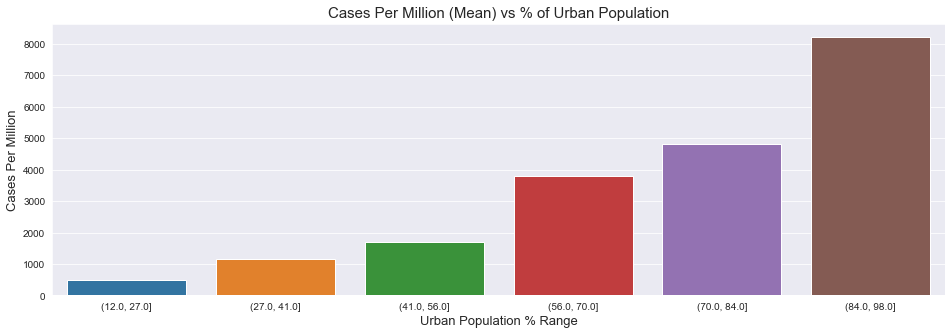

In [88]:

Urban_pop_df = master_df.groupby(by = 'Urban_pop_pct_bins')['Cases Per Million'].mean().reset_index()

fig, ax1 = plt.subplots(figsize = (16,5))
sns.barplot(Urban_pop_df['Urban_pop_pct_bins'],Urban_pop_df['Cases Per Million'],ax = ax1)
sns.set_style(style = 'darkgrid')
plt.xlabel('Urban Population % Range',fontsize=13)
plt.ylabel('Cases Per Million',fontsize=13)
plt.title('Cases Per Million (Mean) vs % of Urban Population',fontsize=15)
plt.show()

In [89]:
fig = px.scatter(data_frame=master_df, x='Urban_pop_pct', y='Cases Per Million',size = 'Cases Per Million',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Urban Population')
fig.update_layout(title_x = .5,autosize=False,width=1000,height=500,xaxis_title="Urban Population %")
fig.show()

### Insights
- Urbanization seems to have a strong correlaton with the infection rates, this probably is due to the fact that people in urban areas tend to socialize and move a lot when compared to rural areas

### 2) GDP 

In [90]:
fig = px.scatter(data_frame=master_df, x=master_df['gdp_usd_million']*1000000/master_df['Population_2020'], y='Cases Per Million',size = 'Cases Per Million',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs GDP Per Capita')
fig.update_layout(title_x = .5,autosize=False,width=1000,height=500,xaxis_title="GDP Per Capita")
fig.show()

### Insights
- High income countries generally have low infection rates but there are exceptions to it

### 3) Age

In [91]:
fig = px.scatter(data_frame=master_df, x='Median_age', y='Cases Per Million',size = 'Cases Per Million',color = 'Country/Region',size_max = 80,title = 'Cases Per Million Population vs Countrywise Median Age')
fig.update_layout(autosize=False,width=1000,height=500,xaxis_title = 'Median Age')
fig.show()

In [92]:
fig = px.scatter(data_frame=master_df, x='Median_age', y='Fatalities Per Million',size = 'Fatalities Per Million',color = 'Country/Region',size_max = 80,title = 'Fatalities Per Million Population vs Countrywise Median Age')
fig.update_layout(title_x = .5,autosize=False,width=1000,height=500,xaxis_title = 'Median Age')
fig.show()

### Insights
- A slight correlation is present, countries having larger median age tend to have a high density of cases as well as fatalities

## Other Factors

### Fatalities Per Million vs ICU Beds

In [93]:
fig = px.scatter(data_frame=master_df,size = 'Fatalities Per Million', size_max = 80,x = 'hosp_beds_per_1000_2017', y='Fatalities Per Million',color = 'Country/Region',title = 'Fatalities Per Million Population vs ICU Beds Per 1000')
fig.update_layout(autosize=False,width=1000,height=500,xaxis_title="Hospital Beds Per 1000")
fig.show()

### Insights
- Some correlation is present here, countries having more ICU beds/1000 see less fatalities per million

# Worldwide Projections

### Forecasting using growth rate

In [94]:
print('Latest Date for which data is available - ',max(Covid_world_df['Date']))
print('Worldwide Confirmed Cases on the latest date are - ',int(Covid_world_df[Covid_world_df['Date'] == max(Covid_world_df['Date'])]['Confirmed Cases'].values))
print('Current Growth Rate - ',np.round(np.array(Covid_world_df['Confirmed Cases'].pct_change())[-8:-1].mean(),3))

Latest Date for which data is available -  2020-09-01 00:00:00
Worldwide Confirmed Cases on the latest date are -  25749642
Current Growth Rate -  0.011


In [95]:
import datetime
prediction_dates = []
predicted_cases = []

start_date = max(Covid_world_df['Date'])
growth_rate = np.array(Covid_world_df['Confirmed Cases'].pct_change())[-1]
previous_day_cases = Covid_world_df[Covid_world_df['Date'] == max(Covid_world_df['Date'])]['Confirmed Cases'].values


for i in range(21):
    
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
    
    predicted_value = previous_day_cases + (previous_day_cases *  growth_rate)
    predicted_cases.append(int(predicted_value))
    previous_day_cases = predicted_value
    
fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines+markers',x = prediction_dates,y = predicted_cases) ) 
fig.update_layout(title_text = 'Worldwide Projections for the next 21 days using growth factor method',title_x = .5,xaxis_title='Dates',yaxis_title='Projected Confirmed Cases')
fig.show()

## Forecasting using SARIMAX 

In [96]:
Covid_world_ARIMA = Covid_world_df[['Date','Confirmed Cases']]
Covid_world_ARIMA = Covid_world_ARIMA.set_index('Date')

In [97]:

def test_stationarity(timeseries,colname):
    
    
    movingAverage = timeseries[colname].rolling(5).mean()
    movingStd = timeseries[colname].rolling(5).std()
    
    plt.close()
    #plot rolling statistics
    plt.figure(figsize= (15,10))
    orig = plt.plot(timeseries[colname],color = 'blue',label = 'Original')
    mean = plt.plot(movingAverage,color = 'red',label = 'Rolling Mean')
    std = plt.plot(movingStd,color = 'black',label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
    
    
    
    print('Results of Dickey-Fueller Test:')
    dftest = adfuller(timeseries[colname],autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistics','P-Value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)
    
    


### Differencing 

In [98]:
df = Covid_world_ARIMA.copy()
df['Logscale'] = np.log(Covid_world_ARIMA['Confirmed Cases'])
df['1st Diff'] = df['Logscale'].diff(periods=1)
df['2nd Diff'] = df['1st Diff'].diff(periods=1)

In [99]:
# def adfuller_test(sales):
#     result=adfuller(sales)
#     labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
#     for value,label in zip(result,labels):
#         print(label+' : '+str(value) )
#     if result[1] <= 0.05:
#         print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [100]:
#test_stationarity(df.dropna(),'2nd Diff')

In [101]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition = seasonal_decompose(df['2nd Diff'].dropna())

# trend = decomposition.trend
# seasonality = decomposition.seasonal
# residual = decomposition.resid


# plt.figure(figsize= (15,10))

# plt.subplot(411)
# plt.plot(df['2nd Diff'].dropna(),label = 'Original')
# plt.legend(loc = 'best')


# plt.subplot(412)
# plt.plot(trend,label = 'Trend')
# plt.legend(loc = 'best')

# plt.subplot(413)
# plt.plot(seasonality,label = 'Seasonality')
# #plt.xaxis_date()
# #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# plt.legend(loc = 'best')

# plt.subplot(414)
# plt.plot(residual,label = 'Residual')
# plt.legend(loc = 'best')

# plt.tight_layout()


In [102]:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(df['2nd Diff'])
# plt.show()

In [103]:
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# import statsmodels.api as sm

# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = sm.graphics.tsa.plot_acf(df['2nd Diff'].dropna(),lags=40,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = sm.graphics.tsa.plot_pacf(df['2nd Diff'].dropna(),lags=40,ax=ax2)

In [104]:
# from statsmodels.tsa.stattools import acf,pacf

# lagacf = acf(df['2nd Diff'].dropna(),nlags=40)
# lagpacf = pacf(df['2nd Diff'].dropna(), nlags=40, method='ols')

# plt.figure(figsize= (15,10))

# plt.subplot(121)
# plt.plot(lagacf)
# plt.axhline(y = 0,linestyle = '--',color = 'gray')
# plt.axhline(y = -1.96/np.sqrt(len(df['2nd Diff'].dropna())),linestyle = '--',color = 'gray')
# plt.axhline(y = 1.96/np.sqrt(len(df['2nd Diff'].dropna())),linestyle = '--',color = 'gray')
# plt.title('Autocorrelation Function')


# plt.subplot(122)
# plt.plot(lagpacf)
# plt.axhline(y = 0,linestyle = '--',color = 'gray')
# plt.axhline(y = -1.96/np.sqrt(len(df['2nd Diff'].dropna())),linestyle = '--',color = 'gray')
# plt.axhline(y = 1.96/np.sqrt(len(df['2nd Diff'].dropna())),linestyle = '--',color = 'gray')
# plt.title('Partial Autocorrelation Function')

In [105]:
from pandas.tseries.offsets import DateOffset

import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Logscale'],order=(1, 2, 1),seasonal_order=(1,2,1,7))
results=model.fit()


future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,21)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_df=pd.concat([df,future_datest_df])
future_df['forecast'] = results.predict(start = (df.shape[0]), end = (df.shape[0])+21, dynamic= True)  

In [106]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=np.exp(future_df['Logscale']),
    x=future_df.index,
    name='Current Cases',
    marker_color='green',mode = 'markers+lines'
))
fig.add_trace(go.Scatter(
    y=np.exp(future_df['forecast']),
    x=future_df.index,
    name='Forecasting',
    marker_color='red',mode = 'markers+lines'
))

fig.add_annotation(
        x=max(future_df.index),
        y=np.round((np.exp(future_df['forecast'])[-1]),2),
        xref="x",
        yref="y",
        text=np.round((np.exp(future_df['forecast'])[-1]),2),
        showarrow=True,
        font=dict(
            family="Courier New, monospace",
            size=14,
            color="#ffffff"
            ),
        align="center",
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#ff7f0e",
        opacity=0.7 )    

fig.update_layout(title_text = 'Predicted Values for the next 21 Days using SARIMAX Model',title_x = .5, xaxis_tickangle=-45,legend_orientation="h",legend=dict(x=.01, y=1.1))
fig.show()